In [4]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

Matplotlib is building the font cache; this may take a moment.


In [6]:
def compute_stats(samples):

  if len(samples) == 0:
    return {
        "mean": 0,
        "std": 0,
        "50th_percentile": 0,
        "90th_percentile": 0,
        "99th_percentile": 0
    }

  stats = {}
  stats["mean"] = np.mean(samples)
  stats["std"] = np.std(samples)

  percentiles = np.quantile(samples, [0.5, 0.9, 0.99])
  stats["50th_percentile"] = percentiles[0]
  stats["90th_percentile"] = percentiles[1]
  stats["99th_percentile"] = percentiles[2]

  return stats


In [11]:
def analyze_benchmarks(
    benchmark_files=PREFILL_BENCHMARK_FILES,
    analyze_col_name="TTFT",
    normalize_by=None,
    bin_by="prompt_len",
    num_bins=10,
    plot_save_dir=PREFILL_PLOT_SAVE_DIR,
    plot_color="blue"
  ):
  """Computes mean, std, median, 90th percentile, and 99th percentile of the
  metric given by analyze_col_name for benchmark files in benchmark_files. Saves
  plots showing how the metric statistics vary with bin_by. If
  normalize_by is not None, normalizes the metrics in analyze_col_name by the
  column normalize_by.
  """
  all_stats_pooled = {}

  metric_name = analyze_col_name
  if normalize_by is not None:
    metric_name = f"{metric_name} by {normalize_by}"

  # First find the min and max prompt length, then compute the bins.
  min_bin_by = 0
  max_bin_by = 0

  raw_dfs = [
      pd.read_csv(benchmark_file) for benchmark_file in benchmark_files
  ]
  min_len = min(len(df) for df in raw_dfs)
  truncated_dfs = [df[:min_len] for df in raw_dfs]

  dfs_to_analyze = []
  for name, df in zip(benchmark_files, truncated_dfs):
    min_bin_by = min(min_bin_by, min(df[bin_by]))
    max_bin_by = max(max_bin_by, max(df[bin_by]))
    dfs_to_analyze.append((name, df))

  bins = np.linspace(min_bin_by, max_bin_by + 1, num=num_bins+1)
  print(f"Bins: {bins}")

  # Plot histograms for 50th, 90th, and 99th percentile JCT by prefill length.
  for prefill_benchmark_file, results_df in dfs_to_analyze:

    experiment_name = prefill_benchmark_file.split("/")[-1].replace(".csv", "")

    # Load df and extract metric to analyze.
    analyze_col = results_df[analyze_col_name]
    if normalize_by is not None:
      analyze_col = analyze_col.divide(results_df[normalize_by])

    # Compute pooled stats.
    curr_stats_pooled = compute_stats(analyze_col.to_list())
    all_stats_pooled_name = \
      f"{experiment_name}-{'_'.join(metric_name.split(' '))}"
    all_stats_pooled[all_stats_pooled_name] = curr_stats_pooled

    stat_names = list(curr_stats_pooled.keys())
    bin_vals = {stat_name: [] for stat_name in stat_names}

    # Compute bin-specific stats.
    for bin_idx in range(num_bins):
      bin_min = bins[bin_idx]
      bin_max = bins[bin_idx + 1]

      larger_than_bin_min = results_df[bin_by] >= bin_min
      less_than_bin_max = results_df[bin_by] < bin_max
      in_bin = [larger_than_bin_min[i] and less_than_bin_max[i]
                for i in range(len(analyze_col))]

      # Extract metric to analyze per bin.
      curr_col_subset = np.array(analyze_col.loc[in_bin].tolist())
      bin_stats = compute_stats(curr_col_subset)

      # Compute per bin stats.
      for stat_name, stat_val in bin_stats.items():
        bin_vals[stat_name].append(stat_val)

    plt.tight_layout()
    # Plot data and save figure.
    for stat_name in stat_names:
      plt.cla()
      plt.stairs(bin_vals[stat_name], bins, color=plot_color, fill=True)
      plt.title(f"{experiment_name} {metric_name}")
      plt.xlabel(bin_by)
      plt.ylabel(stat_name)

      plt_save_dir = os.path.join(plot_save_dir, metric_name, stat_name)
      os.makedirs(plt_save_dir, exist_ok=True)

      plt_file_name = f"{experiment_name}_{stat_name}.png"
      plt.savefig(os.path.join(plt_save_dir, plt_file_name))
      plt.show()

  return all_stats_pooled

In [269]:
COL_NAME_TO_PLOT_KEY = {
    "gen_len": "Num Output Tokens",
    "prompt_len": "Num Input Tokens",
    "TPODT": "TPOT",
    "TTFPT": "TTFT",
    "TTFT": "TTFT",
    "JCT": "JCT"
}

def analyze_benchmarks_overlaid(
    benchmark_files=PREFILL_BENCHMARK_FILES,
    analyze_col_name="TTFT",
    normalize_by=None,
    bin_by="prompt_len",
    num_bins=10,
    plot_save_dir=PREFILL_PLOT_OVERLAID_SAVE_DIR,
  ):
  """Computes mean, std, median, 90th percentile, and 99th percentile of the
  metric given by analyze_col_name for benchmark files in benchmark_files. Saves
  plots showing how the metric statistics vary with bin_by. If
  normalize_by is not None, normalizes the metrics in analyze_col_name by the
  column normalize_by.
  """
  all_stats_pooled = {}

  metric_name = analyze_col_name
  if normalize_by is not None:
    metric_name = f"{metric_name} by {normalize_by}"

  # First find the min and max prompt length, then compute the bins.
  min_bin_by = 0
  max_bin_by = 0

  raw_dfs = [
      pd.read_csv(benchmark_file) for benchmark_file in benchmark_files
  ]
  min_len = min(len(df) for df in raw_dfs)
  truncated_dfs = [df[:min_len] for df in raw_dfs]

  dfs_to_analyze = []
  for name, df in zip(benchmark_files, truncated_dfs):
    min_bin_by = min(min_bin_by, min(df[bin_by]))
    max_bin_by = max(max_bin_by, max(df[bin_by]))
    dfs_to_analyze.append((name, df))

  bins = np.linspace(min_bin_by, max_bin_by + 1, num=num_bins+1)
  print(f"Bins: {bins}")

  bin_vals_by_experiment_name = {}

  # Plot histograms for 50th, 90th, and 99th percentile JCT by prefill length.
  for prefill_benchmark_file, results_df in dfs_to_analyze:

    experiment_name = prefill_benchmark_file.split("/")[1].replace(".csv", "")

    # Load df and extract metric to analyze.
    analyze_col = results_df[analyze_col_name]
    if normalize_by is not None:
      analyze_col = analyze_col.divide(results_df[normalize_by])

    # Compute pooled stats.
    curr_stats_pooled = compute_stats(analyze_col.to_list())
    all_stats_pooled_name = \
      f"{experiment_name}-{'_'.join(metric_name.split(' '))}"
    all_stats_pooled[all_stats_pooled_name] = curr_stats_pooled

    stat_names = list(curr_stats_pooled.keys())
    bin_vals = {stat_name: [] for stat_name in stat_names}

    # Compute bin-specific stats.
    for bin_idx in range(num_bins):
      bin_min = bins[bin_idx]
      bin_max = bins[bin_idx + 1]

      larger_than_bin_min = results_df[bin_by] >= bin_min
      less_than_bin_max = results_df[bin_by] < bin_max
      in_bin = [larger_than_bin_min[i] and less_than_bin_max[i]
                for i in range(len(analyze_col))]

      # Extract metric to analyze per bin.
      curr_col_subset = np.array(analyze_col.loc[in_bin].tolist())
      bin_stats = compute_stats(curr_col_subset)

      # Compute per bin stats.
      for stat_name, stat_val in bin_stats.items():
        bin_vals[stat_name].append(stat_val)

      bin_vals_by_experiment_name[experiment_name] = bin_vals

  # Create and save overlaid plot.
  plt.tight_layout()
  for stat_name in stat_names:
    plt.cla()
    
    for experiment_name, bin_vals in bin_vals_by_experiment_name.items():
      pretty_experiment_name = experiment_name.replace(f"_{RPS}_rps", "")
      if pretty_experiment_name == "fcfs":
          pretty_experiment_name = "fcfs_fcfs"
      plt.stairs(bin_vals[stat_name], bins, label=pretty_experiment_name, fill=False, linewidth=1)

    pretty_stat_name = " ".join(stat_name.split("_"))

    title = f"{pretty_stat_name} {COL_NAME_TO_PLOT_KEY[analyze_col_name]}"
    if normalize_by is not None:
        title = f"{title} per {COL_NAME_TO_PLOT_KEY[normalize_by]}"
    
    plt.title(title)
    plt.xlabel(COL_NAME_TO_PLOT_KEY[bin_by])
    # plt.ylabel(stat_name)

    ylabel = "Seconds"
    if normalize_by == "gen_len":
        ylabel = "Seconds per output token"
    if normalize_by == "prompt_len":
        ylabel = "Seconds per input token"
      
    plt.ylabel(ylabel)
    plt.legend()

    plt_save_dir = os.path.join(plot_save_dir, metric_name, stat_name)
    os.makedirs(plt_save_dir, exist_ok=True)

    plt_file_name = f"{stat_name}.png"
    plt.savefig(os.path.join(plt_save_dir, plt_file_name), dpi=300)
    plt.show()

  # Create stats df.
  df_dict = {stat_name: [] for stat_name in stat_names}
  df_dict["name"] = []
  for experiment_name, stats in all_stats_pooled.items():
    df_dict["name"].append(experiment_name)
    for stat_name, stat_val in stats.items():
     df_dict[stat_name].append(stat_val)

  stats_df = pd.DataFrame(df_dict)
  print(stats_df)

  stats_df.to_csv(f"{os.path.join(plot_save_dir, metric_name, "stats.csv")}")

  return all_stats_pooled

In [276]:
# BENCHMARK_DIRS = [os.path.join("bs_16_sched_32", subdir) for subdir in os.listdir("bs_16_sched_32") if "8_rps" in subdir]

RPS = 2

METHODS = [
    # "fcfs",
    "fcfs_mlfq",
    # "srpt_fcfs",
    "srpt_mlfq",
]

BENCHMARK_DIRS = [
    os.path.join("bs_16_sched_32/", f"{method}_{RPS}_rps") for method in METHODS
]


PREFILL_BENCHMARK_FILES = [
    os.path.join(benchmark_dir, "benchmark_results.csv") for benchmark_dir in BENCHMARK_DIRS
]

PREFILL_PLOT_SAVE_DIR = "prefill_plots/"
PREFILL_PLOT_OVERLAID_SAVE_DIR = "prefill_plots_overlaid/"
os.makedirs(PREFILL_PLOT_SAVE_DIR, exist_ok=True)
os.makedirs(PREFILL_PLOT_OVERLAID_SAVE_DIR, exist_ok=True)

In [277]:
BENCHMARK_DIRS

['bs_16_sched_32/fcfs_mlfq_2_rps', 'bs_16_sched_32/srpt_mlfq_2_rps']

Bins: [  0.   95.1 190.2 285.3 380.4 475.5 570.6 665.7 760.8 855.9 951. ]


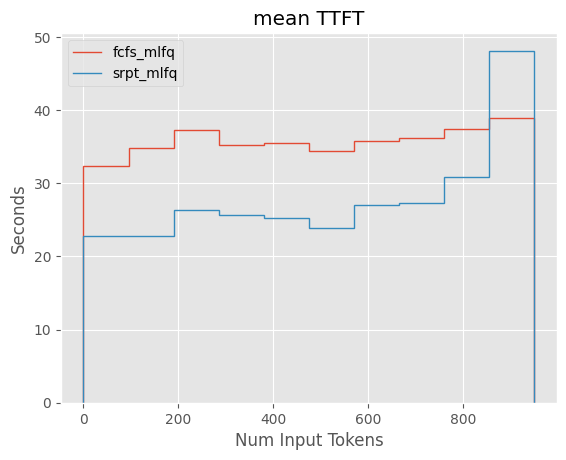

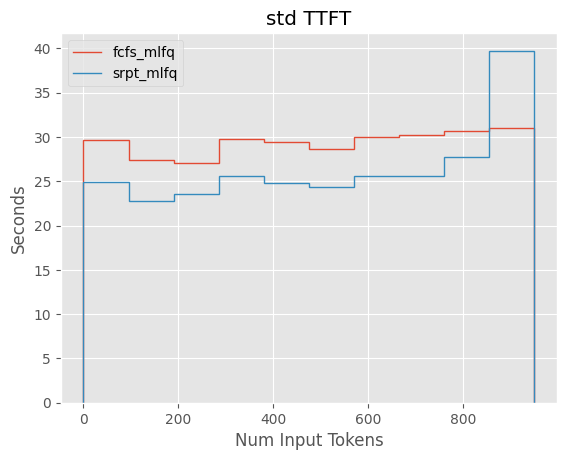

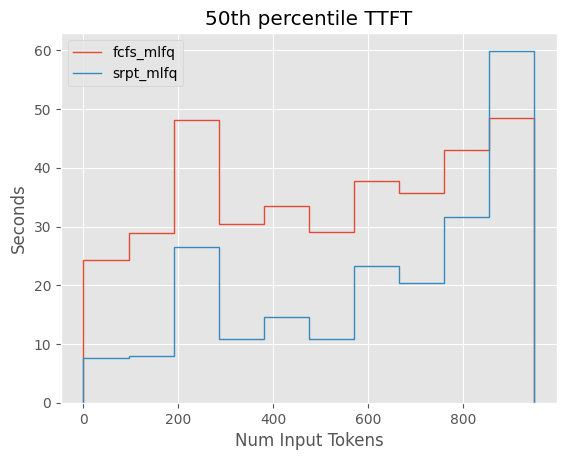

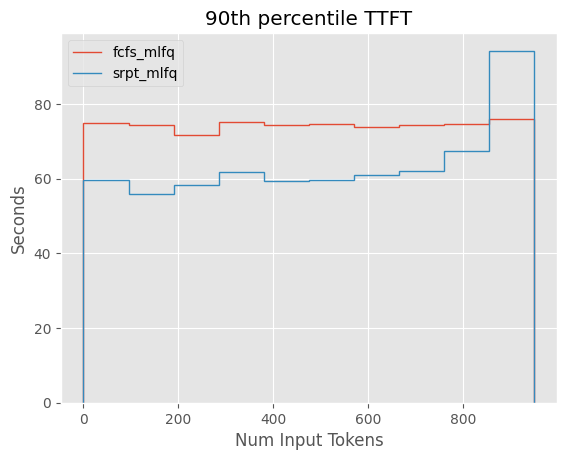

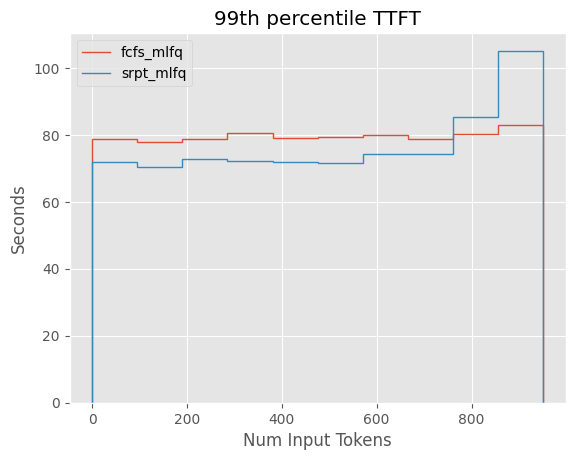

        mean        std  50th_percentile  90th_percentile  99th_percentile  \
0  36.106719  30.014345          31.9015          74.7398         80.62399   
1  30.200901  29.697737          22.9290          70.4953        100.17048   

                    name  
0  fcfs_mlfq_2_rps-TTFPT  
1  srpt_mlfq_2_rps-TTFPT  


{'fcfs_mlfq_2_rps-TTFPT': {'mean': 36.1067192,
  'std': 30.014345376242197,
  '50th_percentile': 31.9015,
  '90th_percentile': 74.73979999999999,
  '99th_percentile': 80.62398999999998},
 'srpt_mlfq_2_rps-TTFPT': {'mean': 30.2009012,
  'std': 29.69773736496837,
  '50th_percentile': 22.929000000000002,
  '90th_percentile': 70.4953,
  '99th_percentile': 100.17047999999994}}

In [278]:
analyze_benchmarks_overlaid(
    benchmark_files=PREFILL_BENCHMARK_FILES,
    analyze_col_name="TTFPT",
    normalize_by=None,
    bin_by="prompt_len",
    num_bins=10,
    plot_save_dir=os.path.join(PREFILL_PLOT_OVERLAID_SAVE_DIR, f"{RPS}_rps"),
)

Bins: [  0.   95.1 190.2 285.3 380.4 475.5 570.6 665.7 760.8 855.9 951. ]


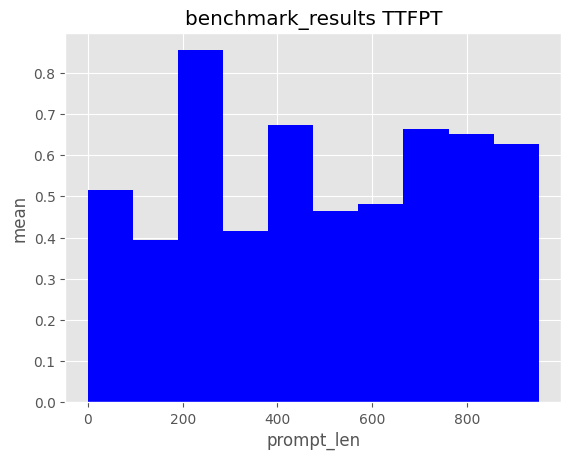

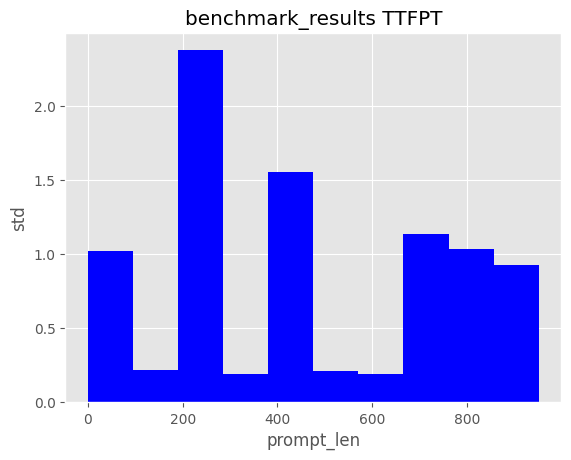

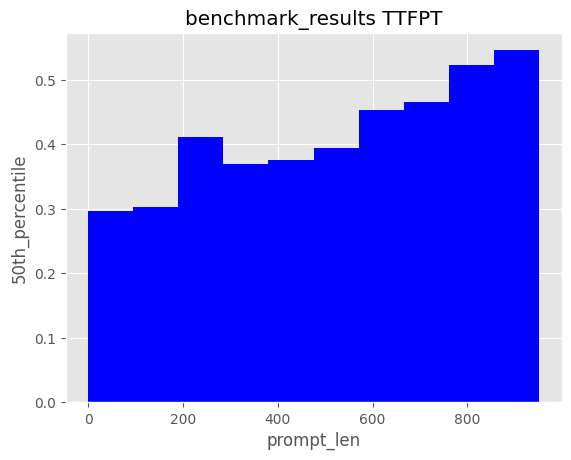

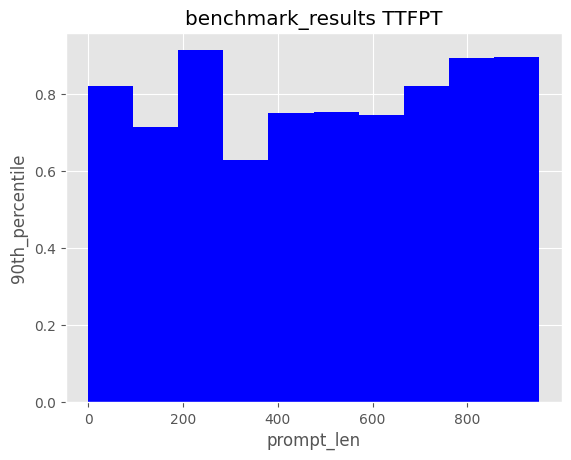

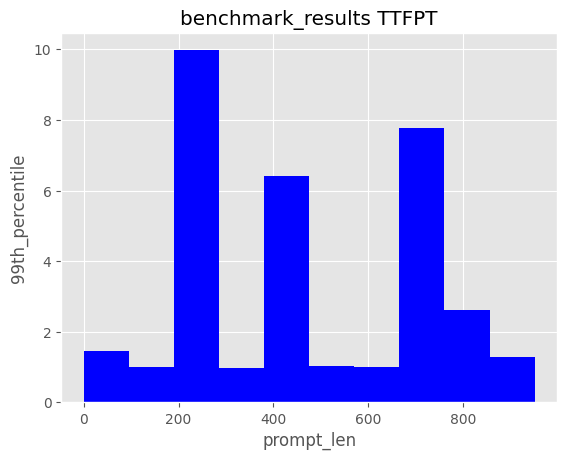

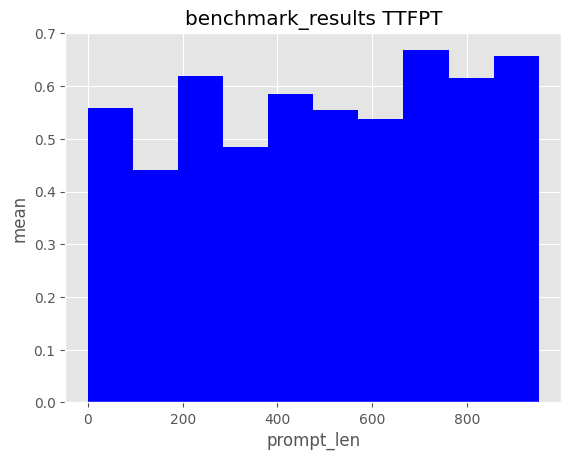

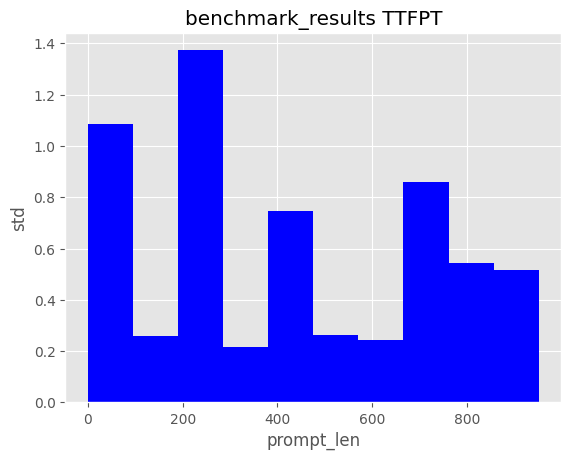

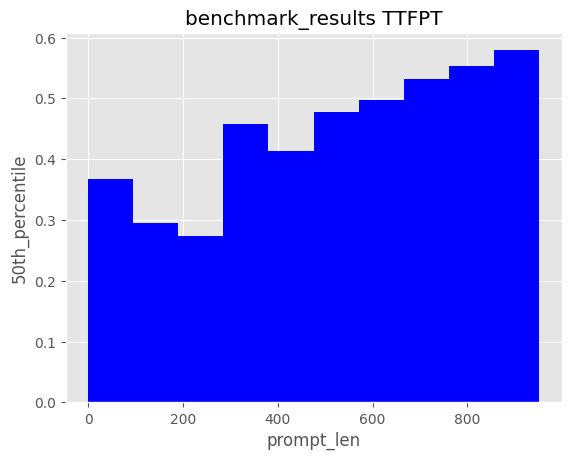

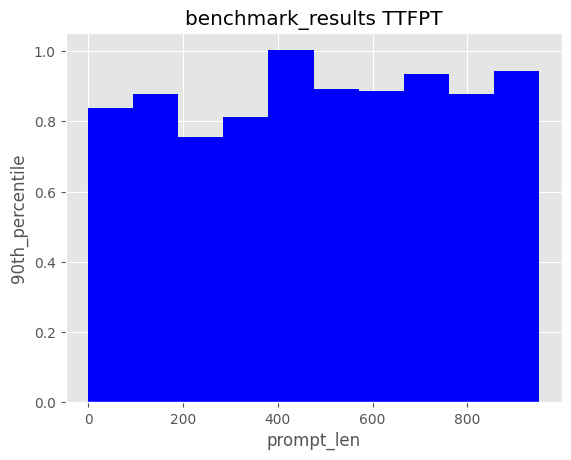

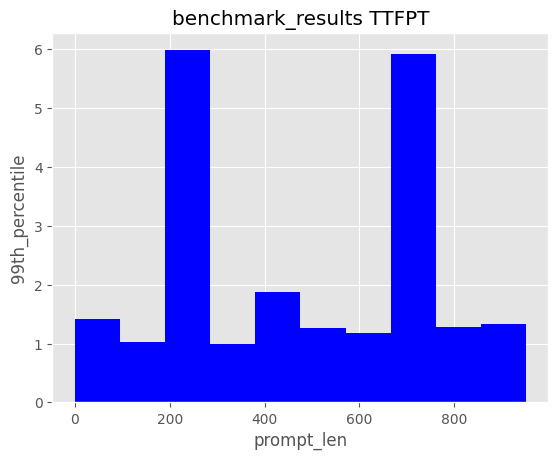

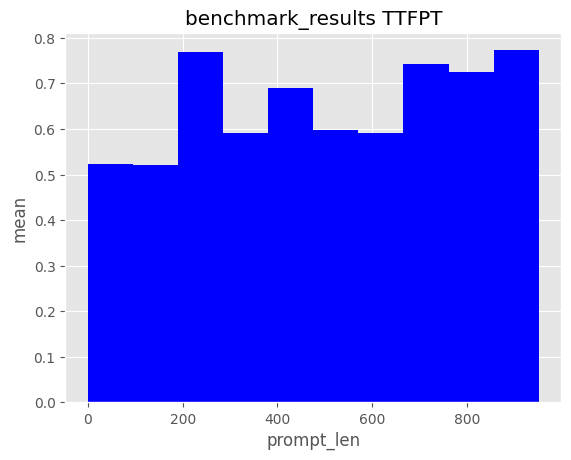

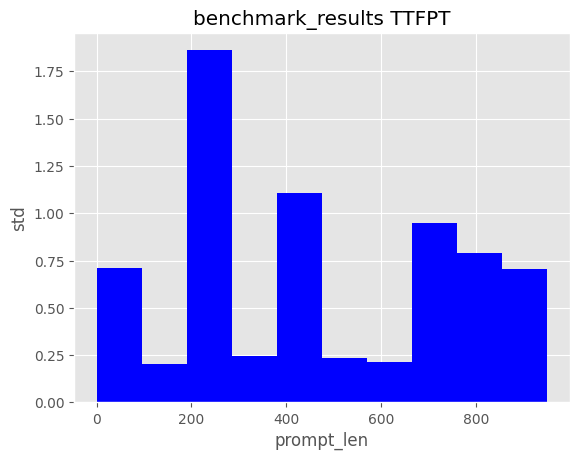

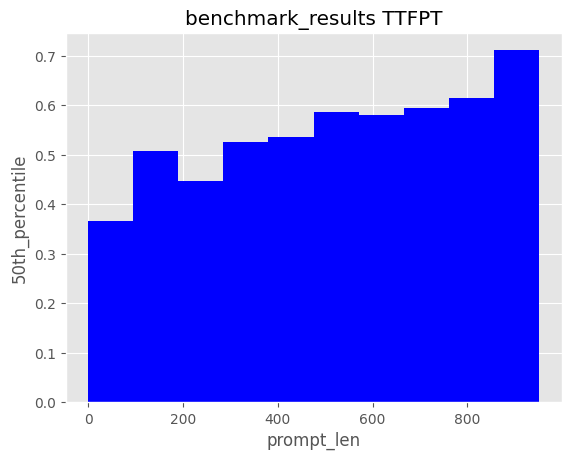

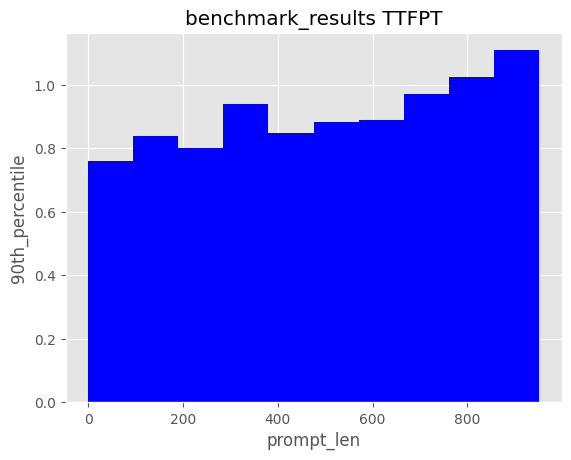

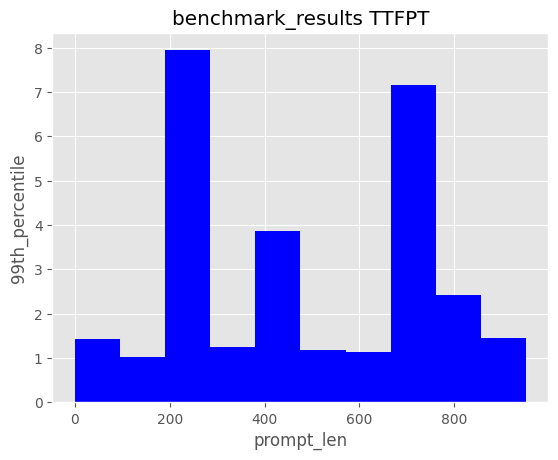

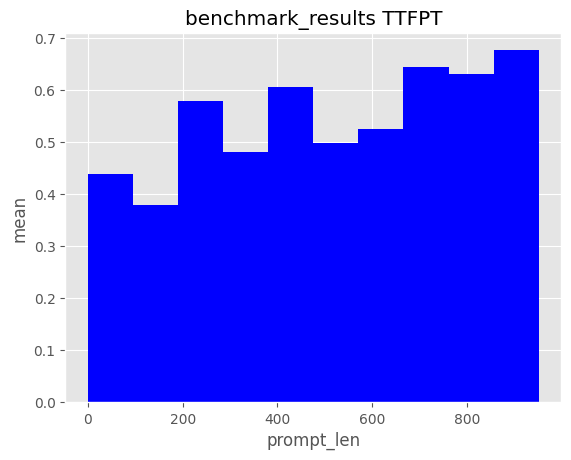

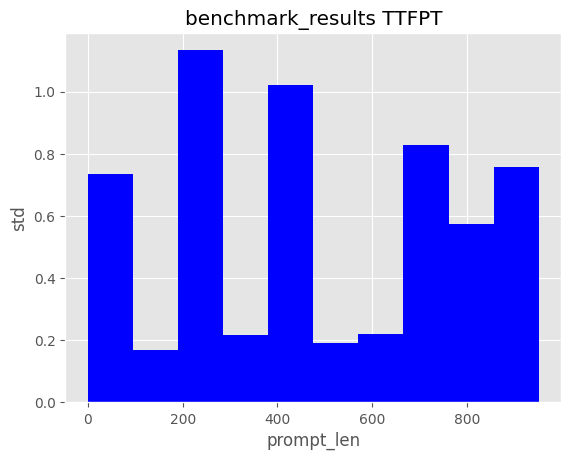

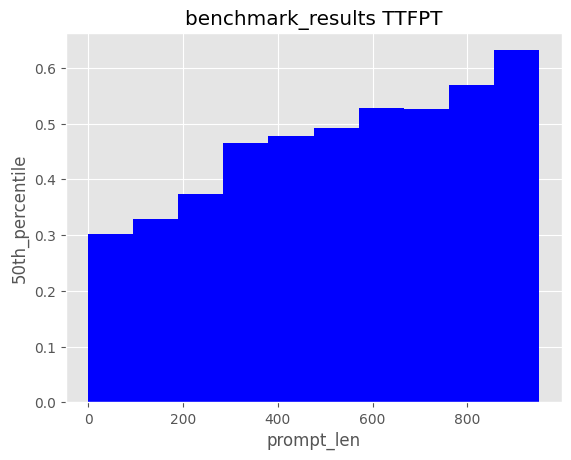

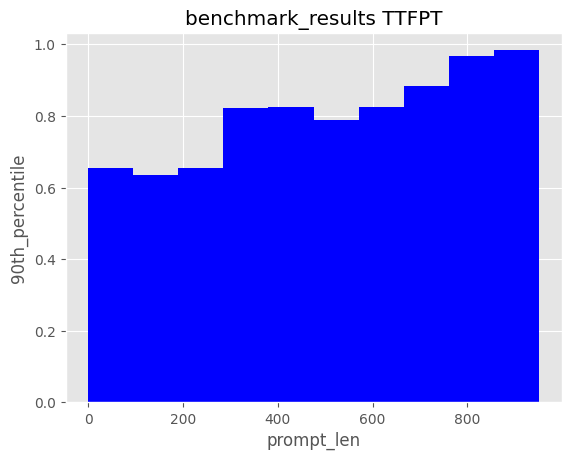

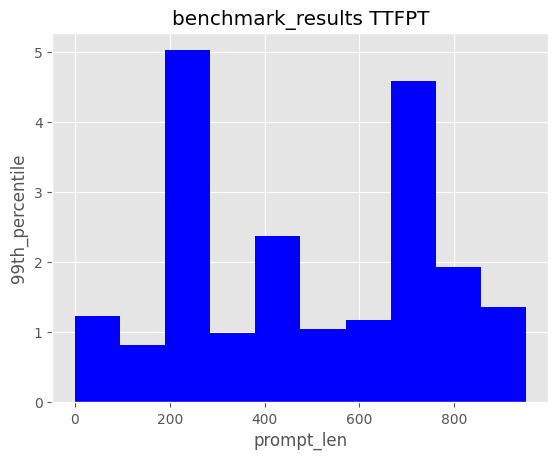

{'benchmark_results-TTFPT': {'mean': 0.571038604305865,
  'std': 0.6762022942004428,
  '50th_percentile': 0.476,
  '90th_percentile': 0.886,
  '99th_percentile': 1.435199999999997}}

In [232]:
analyze_benchmarks(
    benchmark_files=PREFILL_BENCHMARK_FILES,
    analyze_col_name="TTFPT",
    normalize_by=None,
    bin_by="prompt_len",
    num_bins=10,
    plot_save_dir=PREFILL_PLOT_SAVE_DIR,
    plot_color="blue"
)